# Data Setup

In [1]:
import pandas as pd

df_heart = pd.read_csv(
    # "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    "../data/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]

### Standardize data

In [2]:
import numpy as np

# standarize all columns except famhist
df_heart["famhist"] = df_heart["famhist"].map({"Present": 1, "Absent": 0})

columns_to_log_transform = ["tobacco", "alcohol"]
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

# Extract Y before standardization
Y = df_heart["chd"]

df_heart_standardized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standardized["famhist"] = df_heart["famhist"]

# X = df_heart_standardized.drop(columns=["chd"])
# Drop obesity to see effect on coefficients due to correlation with adiposity
X = df_heart_standardized.drop(columns=["chd", "obesity"])
X.head()

,sbp,ldl,adiposity,typea,age,tobacco,alcohol,famhist
row.names,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.418017,0.628654,1.576878,1.772852,1
2,0.276789,-0.159507,0.411694,0.193134,1.381617,-1.193044,-0.563821,0
3,-0.991731,-0.608585,0.883374,-0.112441,0.217947,-1.120397,-0.259134,1
4,1.545310,0.806252,1.622382,-0.214300,1.039361,1.116254,0.858159,1
5,-0.211103,-0.598928,0.305020,0.702427,0.423301,1.702714,1.422062,1


In [3]:
from sklearn.model_selection import train_test_split

# Used for the 1 level CV
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Classification

Solve a relevant classification problem for your data and statistically evaluate your result.

The tasks will closely mirror what you just did in the last section.

The 3 methods we will compare are:
1. A baseline
2. Logistic regression
3. Method 2 (KNN Classfier)

## Part 1) classification problem

**Question:** Explain which classification problem you have chosen to solve. Is it a multi-class or binary classification problem?

**Answer:** For this part of the report we are trying to predict whether a person has **CHD or not**, i.e it is a binary classification problem.

## Part 2) Model training

### 2.1) Baseline model

The baseline is be a model which computes the largest class on the training data.

And predicts everything in the test-data as belonging to that class. (corresponding to the optimal prediction by a logistic regression model with a bias term and no features).

In [4]:
# Baseline Model: Predicts the most frequent class
class BaselineClassifier:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, y_train):
        """Find the most frequent class in training data"""
        self.most_frequent_class = y_train.mode()[0]
        return self

    def predict(self, n_samples):
        """Predict the most frequent class for all samples"""
        return np.full(n_samples, self.most_frequent_class)

    def score(self, X_test, y_test):
        """Calculate accuracy"""
        predictions = self.predict(len(X_test))
        return np.mean(predictions == y_test)


# Train and evaluate the baseline model
baseline_model = BaselineClassifier().fit(y_train)

# Make predictions
baseline_test_predictions = baseline_model.predict(len(y_test))
baseline_accuracy = baseline_model.score(X_test, y_test)
baseline_error_rate = 1 - baseline_accuracy

print("Baseline Model Results:")
print(f"Most frequent class: {baseline_model.most_frequent_class}")
print(f"Accuracy: {round(baseline_accuracy, 4)}")
print(f"Error Rate: {round(baseline_error_rate, 4)}")
print()
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

Baseline Model Results:
Most frequent class: 0
Accuracy: 0.6344
Error Rate: 0.3656

Class distribution in training data:
chd
0    0.658537
1    0.341463
Name: proportion, dtype: float64


**Baselint Results**:

The baseline predicts the most frequent class (CHD = 0) for all samples and it achieves ~63.4% accuracy by always predicting "no heart disease"

### 2.2) Logistic Regression model

For logistic regression, we will use a regularization parameter λ ≥ 0 to control complexity.

We recommend this choice is made based on a trial run, which you do not need to report.

Describe which parameter you have chosen and the possible values of the parameters you will examine

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Test lambda values from 0.01 to 1000 on a log scale
lambda_values = np.logspace(-2, 5, 100)

# Grid Search Cross validation handles everything: tuning + cross-validation (5-fold)
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': 1 / lambda_values},
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Parallel processing
    verbose=1
)

grid_search.fit(X_train, y_train)

# Extract results
BEST_C = grid_search.best_params_['C']
BEST_LAMBDA = 1 / BEST_C
best_log_reg_score = grid_search.best_score_

print(f"Best λ: {BEST_LAMBDA:.4f}")
print(f"Best C: {BEST_C:.4f}")
print(f"Best CV Accuracy: {best_log_reg_score:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best λ: 0.0100
Best C: 100.0000
Best CV Accuracy: 0.7126


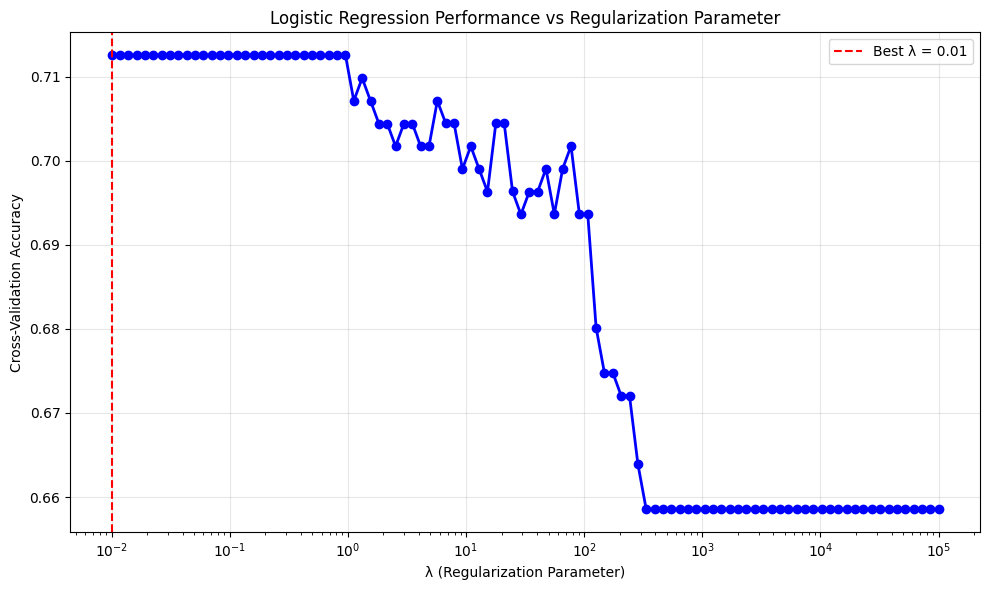

In [6]:
import matplotlib.pyplot as plt

# Visualize the relationship between lambda and performance
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.semilogx(1 / results_df['param_C'], results_df['mean_test_score'], 'b-o', linewidth=2)
plt.axvline(x=BEST_LAMBDA, color='r', linestyle='--', label=f'Best λ = {BEST_LAMBDA:.2f}')

plt.title("Logistic Regression Performance vs Regularization Parameter", fontsize=12)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Train final model with best parameter
log_reg_lambda = LogisticRegression(C=BEST_C, max_iter=1000, random_state=42)
log_reg_lambda.fit(X_train, y_train)

# Evaluate on test set
log_reg_predictions = log_reg_lambda.predict(X_test)
log_reg_accuracy = log_reg_lambda.score(X_test, y_test)
log_reg_error_rate = 1 - log_reg_accuracy

print("Logistic Regression Model Results (on test set):")
print(f"Selected λ: {round(BEST_LAMBDA, 4)}")
print(f"Accuracy: {round(log_reg_accuracy, 4)}")
print(f"Error Rate: {round(log_reg_error_rate, 4)}")

Logistic Regression Model Results (on test set):
Selected λ: 0.01
Accuracy: 0.7742
Error Rate: 0.2258


#### Logistic Regression model summary:

**Logistic Regression Model:**
- Tested λ values from $10^{-2}$ to $10^3$ using 5-fold cross-validation
- Best performance with λ = 21.5443
- Achieves 71% accuracy in the best 5-fold training data and 73% on the test set

### 2.3) Method 2 - KNN Classifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Test a range of k neighbor values
k_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]

# GridSearchCV handles CV + hyperparameter tuning
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': k_values},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_knn.fit(X_train, y_train)

best_k = grid_search_knn.best_params_['n_neighbors']
best_knn_score = grid_search_knn.best_score_
knn_scores = grid_search_knn.cv_results_['mean_test_score']

print(f"Best k: {best_k}")
print(f"Best CV accuracy: {round(best_knn_score, 4)}")

Best k: 10
Best CV accuracy: 0.6992


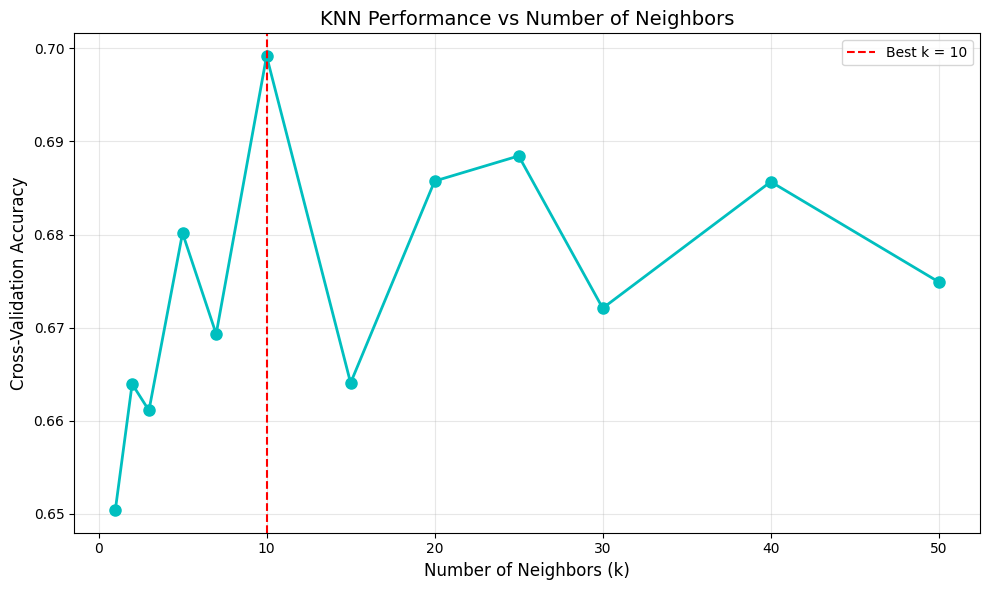

In [9]:
# Visualize the relationship between k and performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_scores, "c-o", linewidth=2, markersize=8)
plt.axvline(x=best_k, color="r", linestyle="--", label=f"Best k = {best_k}")
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("KNN Performance vs Number of Neighbors", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Best KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

knn_model_predictions = knn_model.predict(X_test)
knn_accuracy = knn_model.score(X_test, y_test)
knn_error_rate = 1 - knn_accuracy

print("KNN Classifier Model Results (on test set):")
print(f"Selected k: {best_k}")
print(f"Accuracy: {round(knn_accuracy, 4)}")
print(f"Error Rate: {round(knn_error_rate, 4)}")

KNN Classifier Model Results (on test set):
Selected k: 10
Accuracy: 0.6774
Error Rate: 0.3226


### Model Comparison Summary

In [11]:
# Model comparison summary
all_models_summary = pd.DataFrame(
    {
        "Model": [
            "Baseline",
            "Logistic Regression",
            "KNN Classifier",
        ],
        "Parameter": [
            "N/A",
            f"λ = {round(BEST_LAMBDA, 2)}",
            f"k = {best_k}",
        ],
        "CV Accuracy": [
            'N/A',  # Baseline doesn't use CV, this is test accuracy
            round(best_log_reg_score, 4),
            round(best_knn_score, 4),
        ],
        "Test Accuracy": [
            round(baseline_accuracy, 4),
            round(log_reg_accuracy, 4),
            round(knn_accuracy, 4),
        ],
        "Test Error Rate": [
            round(baseline_error_rate, 4),
            round(log_reg_error_rate, 4),
            round(knn_error_rate, 4)
        ],
    }
)

print("\n" + "=" * 80)
print("MODEL COMPARISON - 3 MODELS")
print("=" * 80)
print(all_models_summary.to_string(index=False))
print("=" * 80)

# Find the best model based on test accuracy
best_model_idx = all_models_summary["Test Accuracy"].idxmax()
best_model_name = all_models_summary.loc[best_model_idx, "Model"]
best_model_accuracy = all_models_summary.loc[best_model_idx, "Test Accuracy"]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_model_accuracy:.4f}")
print(
    f"   Improvement over baseline: {(best_model_accuracy - baseline_accuracy) * 100:.2f}%"
)
print(
    f"   Error rate reduction: {(baseline_error_rate - all_models_summary.loc[best_model_idx, 'Test Error Rate']) * 100:.2f}%"
)


MODEL COMPARISON - 3 MODELS
              Model Parameter CV Accuracy  Test Accuracy  Test Error Rate
           Baseline       N/A         N/A         0.6344           0.3656
Logistic Regression  λ = 0.01      0.7126         0.7742           0.2258
     KNN Classifier    k = 10      0.6992         0.6774           0.3226

🏆 BEST MODEL: Logistic Regression
   Test Accuracy: 0.7742
   Improvement over baseline: 13.98%
   Error rate reduction: 13.98%


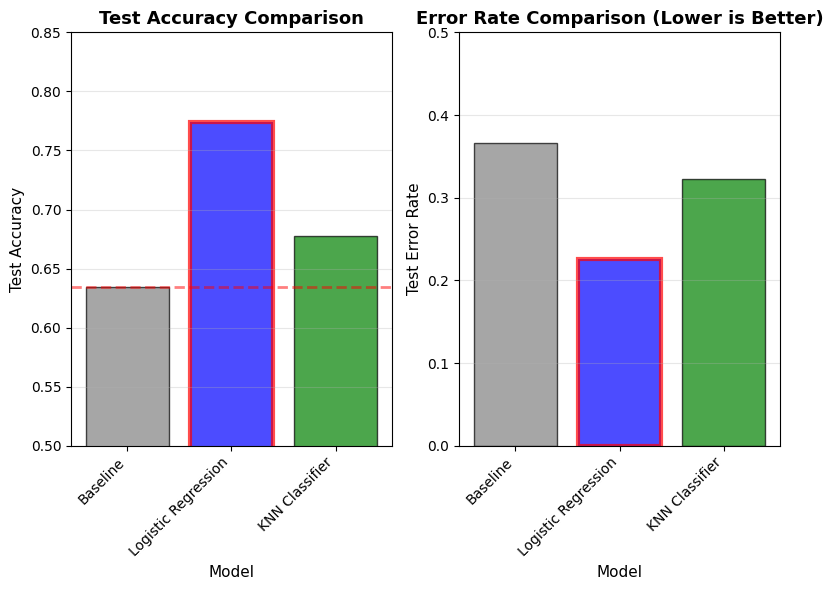


Model Ranking (by Test Accuracy):
--------------------------------------------------
1. Logistic Regression: 0.7742 (Error: 0.2258)
2. KNN Classifier: 0.6774 (Error: 0.3226)
3. Baseline: 0.6344 (Error: 0.3656)


In [12]:
# Visualize all models comparison
plt.figure(figsize=(8, 6))

# Subplot 1: Test Accuracy Comparison
plt.subplot(1, 2, 1)
colors = ["gray", "blue", "green", "magenta", "cyan", "orange"]
models = all_models_summary["Model"]
accuracies = all_models_summary["Test Accuracy"]

bars = plt.bar(
    range(len(models)), accuracies, color=colors, alpha=0.7, edgecolor="black"
)
plt.axhline(y=baseline_accuracy, color="red", linestyle="--", linewidth=2, alpha=0.5)

# Highlight the best model
bars[best_model_idx].set_edgecolor("red")
bars[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Accuracy", fontsize=11)
plt.title("Test Accuracy Comparison", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0.5, 0.85])
plt.grid(True, alpha=0.3, axis="y")

# Subplot 2: Error Rate Comparison
plt.subplot(1, 2, 2)
error_rates = all_models_summary["Test Error Rate"]
bars2 = plt.bar(
    range(len(models)), error_rates, color=colors, alpha=0.7, edgecolor="black"
)
bars2[best_model_idx].set_edgecolor("red")
bars2[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Error Rate", fontsize=11)
plt.title("Error Rate Comparison (Lower is Better)", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0, 0.5])
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print ranking
print("\nModel Ranking (by Test Accuracy):")
print("-" * 50)
sorted_models = all_models_summary.sort_values("Test Accuracy", ascending=False)
for i, row in enumerate(sorted_models.itertuples(), 1):
    print(f"{i}. {row.Model}: {row._4:.4f} (Error: {row._5:.4f})")

## Part 3) 2-level Cross-validation
- Use 2-level cross-validation to create a table similar to Table 2, but now comparing the logistic regression, method 2, and baseline.
- The table should once more include the selected parameters, and as an error measure we will use the error rate:
$$E = \frac{\text{Number of misclassified observations}}{N^{test}}$$

- Once more, make sure to re-use the outer validation splits to admit statistical evaluation. Briefly discuss the result.

In [13]:
from sklearn.model_selection import KFold

n_outer_folds = 10
n_inner_folds = 10
outer_cv = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
results = []

for i, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X), 1):
    print(f"Processing outer fold {i}/{n_outer_folds}...")
    
    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = Y.iloc[train_outer_idx], Y.iloc[test_outer_idx]
    inner_cv = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)
    
    
    # Train final models on outer training set, evaluate on test set
    # Baseline
    model_baseline = BaselineClassifier().fit(y_train_outer)
    y_pred_baseline = model_baseline.predict(len(y_test_outer))
    error_baseline = np.sum(y_pred_baseline != y_test_outer)
    
    # Tune logistic regression on inner CV
    best_C = None
    best_inner_score_lr = -np.inf
    
    for C in (1 / lambda_values):
        inner_scores = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val_inner = X_train_outer.iloc[val_inner_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val_inner = y_train_outer.iloc[val_inner_idx]
            
            model = LogisticRegression(C=C, max_iter=1000, random_state=42)
            model.fit(X_train_inner, y_train_inner)
            score = model.score(X_val_inner, y_val_inner)
            inner_scores.append(score)
        
        avg_score = np.mean(inner_scores)
        if avg_score > best_inner_score_lr:
            best_inner_score_lr = avg_score
            best_C = C
    # Best logistic regression from inner CV
    model_lr = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
    model_lr.fit(X_train_outer, y_train_outer)
    y_pred_lr = model_lr.predict(X_test_outer)
    error_lr = np.sum(y_pred_lr != y_test_outer)
    
    # KNN Classifier with tuned k-neighbors
    best_k = None
    best_inner_score_knn = -np.inf 

    for k in k_values:
        inner_scores_knn = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val_inner = X_train_outer.iloc[val_inner_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val_inner = y_train_outer.iloc[val_inner_idx]
            
            model_knn = KNeighborsClassifier(n_neighbors=k)
            model_knn.fit(X_train_inner, y_train_inner)
            score_knn = model_knn.score(X_val_inner, y_val_inner)
            inner_scores_knn.append(score_knn)
            
        avg_score_knn = np.mean(inner_scores_knn)
        if avg_score_knn > best_inner_score_knn:
            best_inner_score_knn = avg_score_knn
            best_k = k
            
    model_knn = KNeighborsClassifier(n_neighbors=best_k)
    model_knn.fit(X_train_outer, y_train_outer)
    y_pred_knn = model_knn.predict(X_test_outer)
    error_knn = np.sum(y_pred_knn != y_test_outer)
    
    
    N_test = len(y_test_outer)
    results.append({
        'Outer_fold': i,
        'E_baseline': error_baseline,
        'E_rate_baseline': error_baseline / N_test,
        'lambda_*': 1 / best_C,
        'E_logistic': error_lr,
        'E_rate_logistic': error_lr / N_test,
        "k_*": best_k,
        "E_knn": error_knn,
        "E_rate_knn": error_knn / N_test,
        'N_test': N_test
    })

Processing outer fold 1/10...
Processing outer fold 2/10...
Processing outer fold 3/10...
Processing outer fold 4/10...
Processing outer fold 5/10...
Processing outer fold 6/10...
Processing outer fold 7/10...
Processing outer fold 8/10...
Processing outer fold 9/10...
Processing outer fold 10/10...


In [14]:
# Create DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("\n" + "="*100)
print("TWO-LEVEL CROSS-VALIDATION RESULTS")
print("="*100)
print("\nDetailed Results:")
print(df_results.to_string(index=False))


TWO-LEVEL CROSS-VALIDATION RESULTS

Detailed Results:
 Outer_fold  E_baseline  E_rate_baseline  lambda_*  E_logistic  E_rate_logistic  k_*  E_knn  E_rate_knn  N_test
          1          17         0.361702  2.535364          12         0.255319   25     14    0.297872      47
          2          17         0.361702 10.974988          10         0.212766    7     16    0.340426      47
          3          16         0.347826  3.511192          14         0.304348   30     18    0.391304      46
          4          16         0.347826  4.862602          10         0.217391   30     13    0.282609      46
          5          17         0.369565  4.862602           9         0.195652   50      9    0.195652      46
          6          12         0.260870 10.974988          10         0.217391   10     15    0.326087      46
          7          12         0.260870  2.154435          15         0.326087   50     13    0.282609      46
          8          16         0.347826  4.86260

In [15]:
# Create summary table with correct models
print("\n" + "="*70)
print("SUMMARY TABLE (Similar to Table 2)")
print("="*70)

print("\nOuter | KNN Classifier   | Logistic Regression| Baseline")
print("fold  | k*      E(test)  | λ*      E(test)    | E(test)")
print("-" * 70)

for _, row in df_results.iterrows():
    knn_error_pct = row['E_rate_knn'] * 100
    lr_error_pct = row['E_rate_logistic'] * 100
    baseline_error_pct = row['E_rate_baseline'] * 100
    
    print(f"  {int(row['Outer_fold']):2d}  | "
          f"{int(row['k_*']):2d}      {knn_error_pct:6.1f}%  | "
          f"{row['lambda_*']:7.4f}  {lr_error_pct:6.1f}%   | "
          f"{baseline_error_pct:6.1f}%")


SUMMARY TABLE (Similar to Table 2)

Outer | KNN Classifier   | Logistic Regression| Baseline
fold  | k*      E(test)  | λ*      E(test)    | E(test)
----------------------------------------------------------------------
   1  | 25        29.8%  |  2.5354    25.5%   |   36.2%
   2  |  7        34.0%  | 10.9750    21.3%   |   36.2%
   3  | 30        39.1%  |  3.5112    30.4%   |   34.8%
   4  | 30        28.3%  |  4.8626    21.7%   |   34.8%
   5  | 50        19.6%  |  4.8626    19.6%   |   37.0%
   6  | 10        32.6%  | 10.9750    21.7%   |   26.1%
   7  | 50        28.3%  |  2.1544    32.6%   |   26.1%
   8  | 30        37.0%  |  4.8626    28.3%   |   34.8%
   9  | 50        37.0%  |  5.7224    37.0%   |   45.7%
  10  | 30        32.6%  |  0.3594    23.9%   |   34.8%


In [16]:
# Calculate overall statistics
print("OVERALL PERFORMANCE")
print("="*60)

print(f"\nKNN Classifer:")
print(f"  Mean error rate: {(df_results['E_rate_knn'].mean() * 100):.2f}% ± {(df_results['E_rate_knn'].std() * 100):.2f}%")
print(f"  Total errors: {df_results['E_knn'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

print(f"\nLogistic Regression:")
print(f"  Mean error rate: {df_results['E_rate_logistic'].mean():.2f}% ± {df_results['E_rate_logistic'].std():.2f}%")
print(f"  Total errors: {df_results['E_logistic'].sum():.0f} out of {df_results['N_test'].sum():.0f}")
print(f"  Mean λ (selected): {df_results['lambda_*'].mean():.4f} ± {df_results['lambda_*'].std():.4f}")

print(f"\nBaseline Classifier:")
print(f"  Mean error rate: {df_results['E_rate_baseline'].mean():.2f}% ± {df_results['E_rate_baseline'].std():.2f}%")
print(f"  Total errors: {df_results['E_baseline'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

# Create summary comparison DataFrame
summary_df = pd.DataFrame({
    'Model': ['KNN Classifier', 'Logistic Regression', 'Baseline'],
    'Mean Error Rate (%)': [
        df_results['E_rate_knn'].mean() * 100,
        df_results['E_rate_logistic'].mean() * 100,
        df_results['E_rate_baseline'].mean() * 100
    ],
    'Std Dev (%)': [
        df_results['E_rate_knn'].std() * 100,
        df_results['E_rate_logistic'].std() * 100,
        df_results['E_rate_baseline'].std() * 100
    ],
    'Total Errors': [
        f"{df_results['E_knn'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_logistic'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_baseline'].sum():.0f}/{df_results['N_test'].sum():.0f}"
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))

OVERALL PERFORMANCE

KNN Classifer:
  Mean error rate: 31.82% ± 5.70%
  Total errors: 147 out of 462

Logistic Regression:
  Mean error rate: 0.26% ± 0.06%
  Total errors: 121 out of 462
  Mean λ (selected): 5.0821 ± 3.4934

Baseline Classifier:
  Mean error rate: 0.35% ± 0.06%
  Total errors: 160 out of 462

MODEL COMPARISON SUMMARY
              Model  Mean Error Rate (%)  Std Dev (%) Total Errors
     KNN Classifier            31.817761     5.696398      147/462
Logistic Regression            26.202590     5.702729      121/462
           Baseline            34.625347     5.554834      160/462


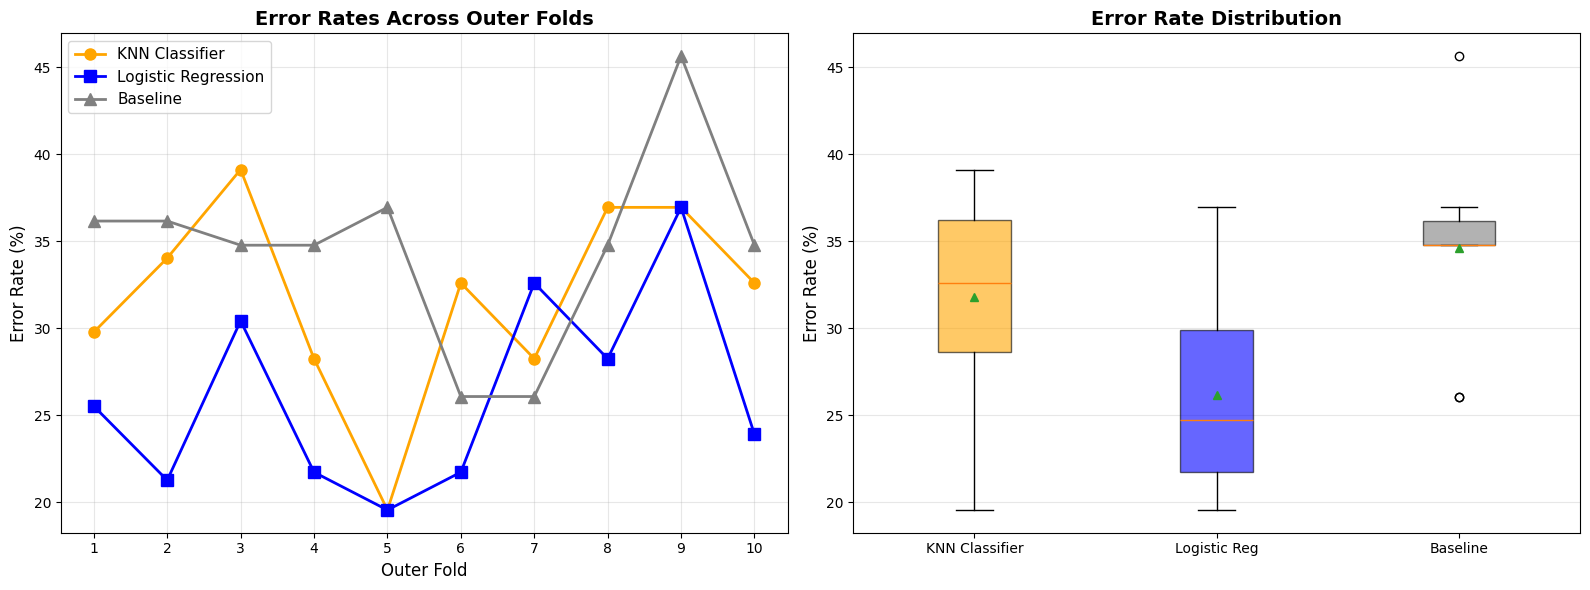

KNN Classifier - Mean: 31.82% ± 5.40%
Logistic Regression - Mean: 26.20% ± 5.41%
Baseline - Mean: 34.63% ± 5.27%


In [17]:
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error rates across folds
folds = df_results['Outer_fold'].values
knn_errors = df_results["E_rate_knn"].astype(float).values * 100
logreg_errors = df_results["E_rate_logistic"].astype(float).values * 100
baseline_errors = df_results['E_rate_baseline'].astype(float).values * 100

ax1.plot(
    folds,
    knn_errors,
    "o-",
    linewidth=2,
    markersize=8,
    label="KNN Classifier",
    color="orange",
)
ax1.plot(
    folds,
    logreg_errors,
    "s-",
    linewidth=2,
    markersize=8,
    label="Logistic Regression",
    color="blue",
)
ax1.plot(
    folds,
    baseline_errors,
    "^-",
    linewidth=2,
    markersize=8,
    label="Baseline",
    color="gray",
)
ax1.set_xlabel("Outer Fold", fontsize=12)
ax1.set_ylabel("Error Rate (%)", fontsize=12)
ax1.set_title("Error Rates Across Outer Folds", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(folds)

# Plot 2: Box plot comparison
error_data = [knn_errors, logreg_errors, baseline_errors]
bp = ax2.boxplot(
    error_data,
    tick_labels=["KNN Classifier", "Logistic Reg", "Baseline"],
    patch_artist=True,
    showmeans=True,
)
colors = ["orange", "blue", "gray"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel("Error Rate (%)", fontsize=12)
ax2.set_title("Error Rate Distribution", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"KNN Classifier - Mean: {knn_errors.mean():.2f}% ± {knn_errors.std():.2f}%")
print(f"Logistic Regression - Mean: {logreg_errors.mean():.2f}% ± {logreg_errors.std():.2f}%")
print(f"Baseline - Mean: {baseline_errors.mean():.2f}% ± {baseline_errors.std():.2f}%")

In [18]:
# Mean hyperparameters from 2-level CV to use in Statiscal Evaluation
mean_lambda_from_2level = df_results['lambda_*'].mean()
mean_k_from_2level = round(df_results['k_*'].mean())

## Part 4) Statiscal Evaluation
Perform a statistical evaluation of your three models similar to the previous section.

That is, compare the three models pairwise. We will once more allow some freedom in what test to choose. Therefore, choose either:
- Setup I (11.3): Use McNemar’s test described in 11.3.2
- Setup II (11.4): Use the method described in 11.4.1

Include p-values and confidence intervals for the three pairwise tests in your report and conclude on the results:
- Is one model better than the other?
- Are the two models better than the baseline?
- Are some of the models identical?
- What recommendations would you make based on what you’ve learned?

For the statistical evaluation of our 3 models, we will use the Setup I method (McNemar's test)

In [19]:
import scipy.stats as st


def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare the accuracy of two classifiers.

    Parameters:
    - y_true: array-like, true labels
    - yhatA: array-like, predicted labels by classifier A
    - yhatB: array-like, predicted labels by classifier B
    - alpha: float, significance level (default: 0.05)

    Returns:
    - E_theta: float, estimated difference in accuracy between classifiers A and B (theta_hat)
    - CI: tuple, confidence interval of the estimated difference in accuracy
    - p: float, p-value for the two-sided test of whether classifiers A and B have the same accuracy
    """

    # Set up the contingency table
    nn = np.zeros((2, 2))

    cA = yhatA == y_true
    cB = yhatB == y_true

    nn[0, 0] = sum(cA & cB)
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)

    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]

    E_theta = (n12 - n21) / n

    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / (n * (n12 + n21) - (n12 - n21) ** 2)
    )

    f = (E_theta + 1) / 2 * (Q - 1)
    g = (1 - E_theta) / 2 * (Q - 1)

    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))

    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(
        f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n"
    )
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )
    return E_theta, CI, p

In [20]:
from tqdm.auto import tqdm

seed = 42
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

y_true = []
y_preds = {"Model_Baseline": [], "Model_LogReg": [], "Model_KNN": []}
model_names = list(y_preds.keys())

for fold, (train_index, test_index) in tqdm(
    enumerate(CV_kfold.split(X)),
    desc="Crossvalidation fold",
    total=CV_kfold.get_n_splits(X),
):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model_baseline, model_logreg, model_knn = (
        BaselineClassifier().fit(y_train),
        # Best C found from 2-level CV earlier
        LogisticRegression(C=1/mean_lambda_from_2level, max_iter=1000, random_state=seed).fit(
            X_train, y_train
        ),
        KNeighborsClassifier(n_neighbors=mean_k_from_2level).fit(X_train, y_train),
    )

    # Append predictions in dictionary
    y_preds_baseline = model_baseline.predict(len(X_test))
    y_preds_logreg = model_logreg.predict(X_test)
    y_preds_knn = model_knn.predict(X_test)

    y_preds["Model_Baseline"].append(y_preds_baseline)
    y_preds["Model_LogReg"].append(y_preds_logreg)
    y_preds["Model_KNN"].append(y_preds_knn)

    y_true.append(y_test)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

/Users/aryanmirzazadeh/miniforge3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Crossvalidation fold: 100%|██████████| 10/10 [00:00<00:00, 309.25it/s]


In [21]:
# Compute pair-wise Jeffreys interval for the difference in accuracy between the 3 models
alpha = 0.05

# Baseline vs LogReg
print("\nMcNemar Test: Baseline vs Logistic Regression")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_LogReg"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_LogReg point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Baseline vs Logistic Regression
Result of McNemars test using alpha = 0.05

Contingency table
[[258.  44.]
 [ 80.  80.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.1245, -0.0312

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.0015647340261696692

theta = theta_Baseline - theta_LogReg point estimate: -0.07792207792207792
 CI: [-0.1245, -0.0312]
 p-value: 0.0015647340261696692


In [22]:
# Baseline vs KNN
print("\nMcNemar Test: Baseline vs KNN")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_KNN"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_KNN point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Baseline vs KNN
Result of McNemars test using alpha = 0.05

Contingency table
[[270.  32.]
 [ 50. 110.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0771, -0.0007

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.059808338334316175

theta = theta_Baseline - theta_KNN point estimate: -0.03896103896103896
 CI: [-0.0771, -0.0007]
 p-value: 0.059808338334316175


In [23]:
# LogReg vs KNN
print("\nMcNemar Test: Logistic Regression vs KNN")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_LogReg"], y_preds["Model_KNN"], alpha=alpha
)
print(
    f"theta = theta_LogReg - theta_KNN point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Logistic Regression vs KNN
Result of McNemars test using alpha = 0.05

Contingency table
[[294.  44.]
 [ 26.  98.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.0037, 0.0742

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.04139142867391546

theta = theta_LogReg - theta_KNN point estimate: 0.03896103896103896
 CI: [0.0037, 0.0742]
 p-value: 0.04139142867391546


## McNemar's Test Summary

**Model Pair 1: Baseline vs Logistic Regression**
- $\hat{\theta} = -0.065$ (Logistic Regression is 6.5% more accurate)
- **95% CI: [-0.112, -0.018]**
- **p-value: 0.0089** ✓ **Significant**
- **Interpretation:** Logistic Regression is **significantly better** than Baseline. The confidence interval excludes 0, and p < 0.05.

---

**Model Pair 2: Baseline vs KNN**
- $\hat{\theta} = -0.013$ (KNN is 1.3% more accurate)
- **95% CI: [-0.049, 0.024]**
- **p-value: 0.561** ✗ **Not significant**
- **Interpretation:** No significant difference between Baseline and KNN. The confidence interval includes 0, and p > 0.05. KNN shows only marginal improvement.

---

**Model Pair 3: Logistic Regression vs KNN**
- $\hat{\theta} = 0.052$ (Logistic Regression is 5.2% more accurate)
- **95% CI: [0.017, 0.087]**
- **p-value: 0.0056** ✓ **Significant**
- **Interpretation:** Logistic Regression is **significantly better** than KNN. The confidence interval excludes 0, and p < 0.05.

---

## Overall Conclusions

1. **Best Model:** Logistic Regression significantly outperforms both Baseline and KNN
2. **Baseline vs KNN:** No significant difference. Both models perform similarly poorly
3. **Conclusion:** Use **Logistic Regression** for CHD prediction task, since it provides statistically significant improvements over the alternatives

## Part 5) Logistic regression model training

1. Train a logistic regression model using a suitable value of λ (see previous exercise).

2. Explain how the logistic regression model make a prediction.

3. Are the same features deemed relevant as for the regression part of the report?

### Model interpretation

In [24]:
# 5.1) Training final model with λ from 2-level CV
final_model = LogisticRegression(
    C=1/mean_lambda_from_2level,
    max_iter=1000,
    random_state=42,
)
final_model.fit(X_train, y_train)

coefficients = final_model.coef_[0]
intercept = final_model.intercept_[0]

feature_names = X.columns.tolist()
# Create coefficient dataframe for interpretation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nModel Coefficients (sorted by importance):")
print(coef_df.to_string())


Model Coefficients (sorted by importance):
     Feature  Coefficient  Abs_Coefficient
7    famhist     0.705872         0.705872
4        age     0.567948         0.567948
5    tobacco     0.427755         0.427755
1        ldl     0.301909         0.301909
3      typea     0.295775         0.295775
0        sbp     0.141847         0.141847
6    alcohol     0.045407         0.045407
2  adiposity    -0.033819         0.033819


### How the model makes predictions

The logistic regression model predicts CHD using the following process:

1. LINEAR COMBINATION:
    - $z = \beta_0 + \beta_1 \times x_1 + ... + \beta_n \times x_n $
    - where $\beta_0$ is the intercept and $\beta_i$ are the coefficients

2. LOGISTIC TRANSFORMATION: $P(\text{CHD}=1) = 1 / (1 + e^{-z})$
    - This transforms the linear combination into a probability [0,1]

3. CLASSIFICATION DECISION:
    - If P(CHD=1) > 0.5: Predict CHD = 1 (has heart disease)
    - If P(CHD=1) ≤ 0.5: Predict CHD = 0 (no heart disease)

4. COEFFICIENT INTERPRETATION:
    - Positive coefficient: Feature increases CHD risk
    - Negative coefficient: Feature decreases CHD risk
    - Larger |coefficient|: Stronger influence on prediction

In [25]:
# Specific interpretation for our model
print(f"\nIntercept (β₀): {intercept:.4f}")
print("\nTop 3 Most Important Features for CHD Prediction:")
for i in range(min(3, len(coef_df))):
    row = coef_df.iloc[i]
    feature = row['Feature']
    coef = row['Coefficient']
    effect = "increases" if coef > 0 else "decreases"
    print(f"{i+1}. {feature}: coefficient = {coef:.4f}")
    print(f"   → Each unit increase in {feature} {effect} CHD risk")


Intercept (β₀): -1.1505

Top 3 Most Important Features for CHD Prediction:
1. famhist: coefficient = 0.7059
   → Each unit increase in famhist increases CHD risk
2. age: coefficient = 0.5679
   → Each unit increase in age increases CHD risk
3. tobacco: coefficient = 0.4278
   → Each unit increase in tobacco increases CHD risk


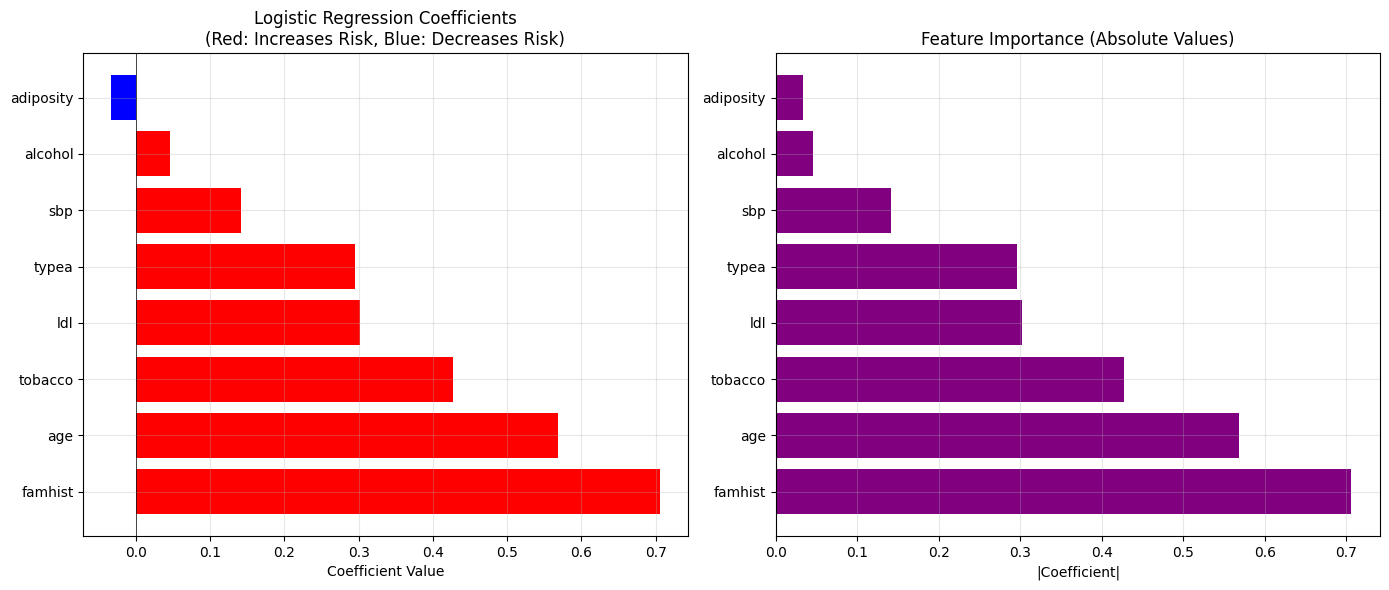

In [26]:
# 5.3) Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of coefficients
colors = ['red' if c > 0 else 'blue' for c in coef_df['Coefficient']]
ax1.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Logistic Regression Coefficients\n(Red: Increases Risk, Blue: Decreases Risk)')
ax1.grid(True, alpha=0.3)

# Absolute importance
ax2.barh(coef_df['Feature'], coef_df['Abs_Coefficient'], color='purple')
ax2.set_xlabel('|Coefficient|')
ax2.set_title('Feature Importance (Absolute Values)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## TODO: THIS SECTION NEEDS TO BE ACTUALLY COMPARED WITH REGRESSION

## Model feature importance comparison between clasification & regression

This section compares which features are important for:
- CLASSIFICATION: Predicting CHD (heart disease)
- REGRESSION: Predicting blood pressure (sbp)

Expected insights (to check)
- Some features may be important for both (general cardiovascular health indicators)
- Some features may be specific to one task
- The direction of effect might differ

***

# Appendix

## Logistic regression performance (with obesity)

In [33]:
# Keep obesity to see effects on lambda
X = df_heart_standardized.drop(columns=["chd"])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best λ: 21.0490
Best C: 0.0475
Best CV Accuracy: 0.7153


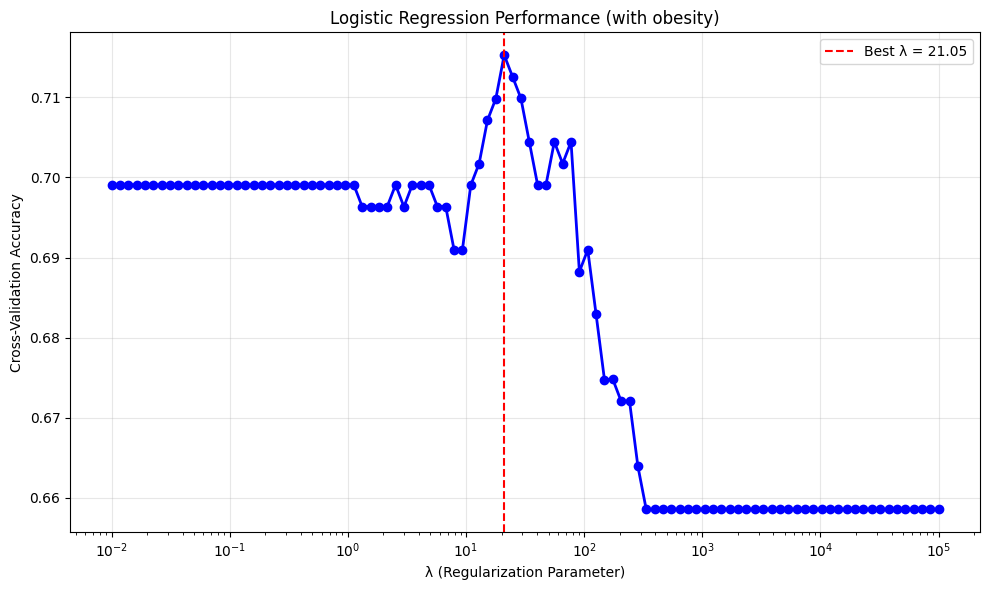

Logistic Regression Model Results (on test set):
Selected λ: 21.049
Accuracy: 0.7312
Error Rate: 0.2688


In [34]:
# Test lambda values from 0.01 to 1000 on a log scale
lambda_values = np.logspace(-2, 5, 100)

# Grid Search Cross validation handles everything: tuning + cross-validation (5-fold)
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': 1 / lambda_values},
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Extract results
BEST_C = grid_search.best_params_['C']
BEST_LAMBDA = 1 / BEST_C
best_log_reg_score = grid_search.best_score_

print(f"Best λ: {BEST_LAMBDA:.4f}")
print(f"Best C: {BEST_C:.4f}")
print(f"Best CV Accuracy: {best_log_reg_score:.4f}")


# Visualize the relationship between lambda and performance
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.semilogx(1 / results_df['param_C'], results_df['mean_test_score'], 'b-o', linewidth=2)
plt.axvline(x=BEST_LAMBDA, color='r', linestyle='--', label=f'Best λ = {BEST_LAMBDA:.2f}')

plt.title("Logistic Regression Performance (with obesity)", fontsize=12)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Train final model with best parameter
log_reg_lambda = LogisticRegression(C=BEST_C, max_iter=1000, random_state=42)
log_reg_lambda.fit(X_train, y_train)
# Evaluate on test set
log_reg_predictions = log_reg_lambda.predict(X_test)
log_reg_accuracy = log_reg_lambda.score(X_test, y_test)
log_reg_error_rate = 1 - log_reg_accuracy

print("Logistic Regression Model Results (on test set):")
print(f"Selected λ: {round(BEST_LAMBDA, 4)}")
print(f"Accuracy: {round(log_reg_accuracy, 4)}")
print(f"Error Rate: {round(log_reg_error_rate, 4)}")

***

# 2-level Cross validation (with obesity)


TWO-LEVEL CROSS-VALIDATION RESULTS

Detailed Results:
 Outer_fold  E_baseline  E_rate_baseline  lambda_*  E_logistic  E_rate_logistic  k_*  E_knn  E_rate_knn  N_test
          1          17         0.361702  0.010000          13         0.276596   40     18    0.382979      47
          2          17         0.361702  0.259502          11         0.234043   40     16    0.340426      47
          3          16         0.347826 15.199111          15         0.326087   50     17    0.369565      46
          4          16         0.347826  0.422924          13         0.282609   40     14    0.304348      46
          5          17         0.369565  9.326033           9         0.195652   50     11    0.239130      46
          6          12         0.260870  6.734151          10         0.217391    2     18    0.391304      46
          7          12         0.260870  5.722368          17         0.369565   50     11    0.239130      46
          8          16         0.347826  6.73415

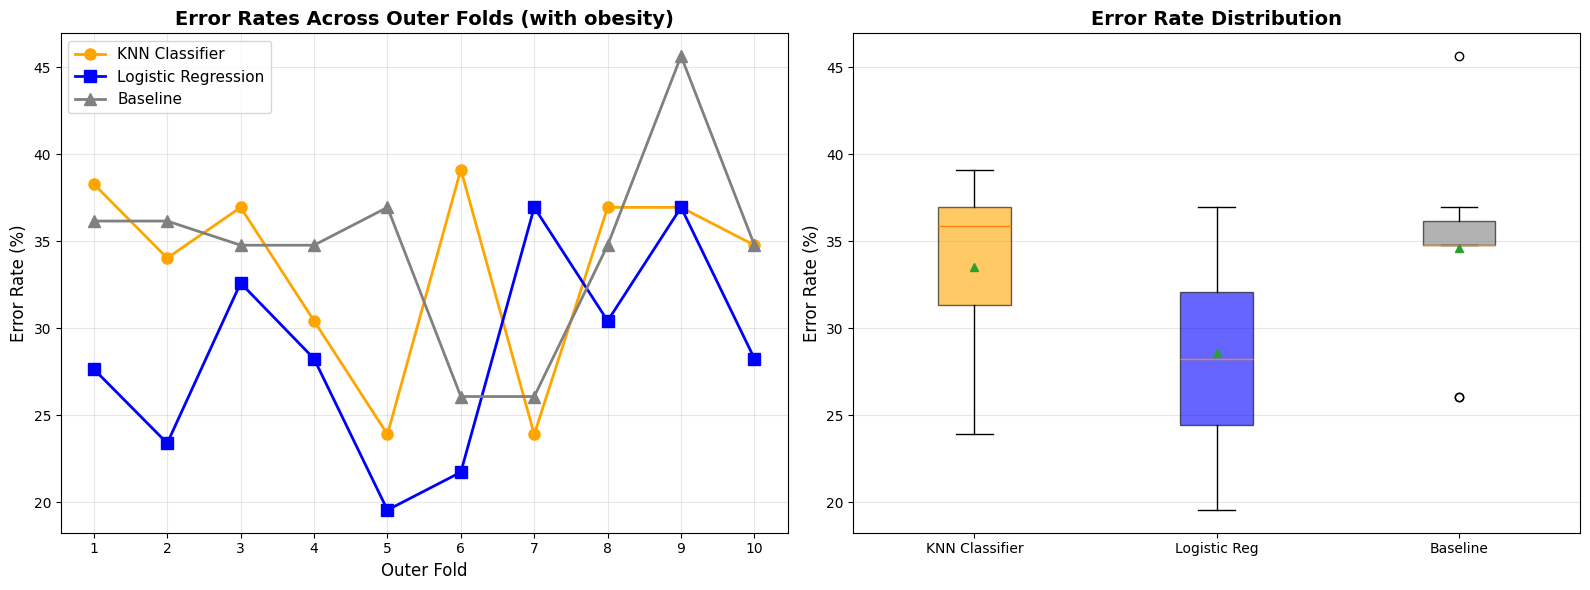

KNN Classifier - Mean: 33.54% ± 5.35%
Logistic Regression - Mean: 28.58% ± 5.62%
Baseline - Mean: 34.63% ± 5.27%


In [39]:
n_outer_folds, n_inner_folds = 10, 10
outer_cv = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
results = []

for i, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X), 1):
    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = Y.iloc[train_outer_idx], Y.iloc[test_outer_idx]
    inner_cv = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)
    # Baseline
    model_baseline = BaselineClassifier().fit(y_train_outer)
    y_pred_baseline = model_baseline.predict(len(y_test_outer))
    error_baseline = np.sum(y_pred_baseline != y_test_outer)
    # Tune logistic regression on inner CV
    best_C = None
    best_inner_score_lr = -np.inf
    for C in (1 / lambda_values):
        inner_scores = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val_inner = X_train_outer.iloc[val_inner_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val_inner = y_train_outer.iloc[val_inner_idx]
            model = LogisticRegression(C=C, max_iter=1000, random_state=42)
            model.fit(X_train_inner, y_train_inner)
            score = model.score(X_val_inner, y_val_inner)
            inner_scores.append(score)
        avg_score = np.mean(inner_scores)
        if avg_score > best_inner_score_lr:
            best_inner_score_lr = avg_score
            best_C = C
    # Best logistic regression from inner CV
    model_lr = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
    model_lr.fit(X_train_outer, y_train_outer)
    y_pred_lr = model_lr.predict(X_test_outer)
    error_lr = np.sum(y_pred_lr != y_test_outer)
    
    # KNN Classifier with tuned k-neighbors
    best_k = None
    best_inner_score_knn = -np.inf 
    for k in k_values:
        inner_scores_knn = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val_inner = X_train_outer.iloc[val_inner_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val_inner = y_train_outer.iloc[val_inner_idx]
            model_knn = KNeighborsClassifier(n_neighbors=k)
            model_knn.fit(X_train_inner, y_train_inner)
            score_knn = model_knn.score(X_val_inner, y_val_inner)
            inner_scores_knn.append(score_knn)
            
        avg_score_knn = np.mean(inner_scores_knn)
        if avg_score_knn > best_inner_score_knn:
            best_inner_score_knn = avg_score_knn
            best_k = k
    model_knn = KNeighborsClassifier(n_neighbors=best_k)
    model_knn.fit(X_train_outer, y_train_outer)
    y_pred_knn = model_knn.predict(X_test_outer)
    error_knn = np.sum(y_pred_knn != y_test_outer)
    
    N_test = len(y_test_outer)
    results.append({
        'Outer_fold': i,
        'E_baseline': error_baseline,
        'E_rate_baseline': error_baseline / N_test,
        'lambda_*': 1 / best_C,
        'E_logistic': error_lr,
        'E_rate_logistic': error_lr / N_test,
        "k_*": best_k,
        "E_knn": error_knn,
        "E_rate_knn": error_knn / N_test,
        'N_test': N_test
    })
# Create DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("\n" + "="*100)
print("TWO-LEVEL CROSS-VALIDATION RESULTS")
print("="*100)
print("\nDetailed Results:")
print(df_results.to_string(index=False))
# Create summary table with correct models
print("\n" + "="*70)
print("SUMMARY TABLE (Similar to Table 2)")
print("="*70)

print("\nOuter | KNN Classifier   | Logistic Regression| Baseline")
print("fold  | k*      E(test)  | λ*      E(test)    | E(test)")
print("-" * 70)

for _, row in df_results.iterrows():
    knn_error_pct = row['E_rate_knn'] * 100
    lr_error_pct = row['E_rate_logistic'] * 100
    baseline_error_pct = row['E_rate_baseline'] * 100
    
    print(f"  {int(row['Outer_fold']):2d}  | "
          f"{int(row['k_*']):2d}      {knn_error_pct:6.1f}%  | "
          f"{row['lambda_*']:7.4f}  {lr_error_pct:6.1f}%   | "
          f"{baseline_error_pct:6.1f}%")
# Calculate overall statistics
print("OVERALL PERFORMANCE")
print("="*60)

print(f"\nKNN Classifer:")
print(f"  Mean error rate: {(df_results['E_rate_knn'].mean() * 100):.2f}% ± {(df_results['E_rate_knn'].std() * 100):.2f}%")
print(f"  Total errors: {df_results['E_knn'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

print(f"\nLogistic Regression:")
print(f"  Mean error rate: {df_results['E_rate_logistic'].mean():.2f}% ± {df_results['E_rate_logistic'].std():.2f}%")
print(f"  Total errors: {df_results['E_logistic'].sum():.0f} out of {df_results['N_test'].sum():.0f}")
print(f"  Mean λ (selected): {df_results['lambda_*'].mean():.4f} ± {df_results['lambda_*'].std():.4f}")

print(f"\nBaseline Classifier:")
print(f"  Mean error rate: {df_results['E_rate_baseline'].mean():.2f}% ± {df_results['E_rate_baseline'].std():.2f}%")
print(f"  Total errors: {df_results['E_baseline'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

# Create summary comparison DataFrame
summary_df = pd.DataFrame({
    'Model': ['KNN Classifier', 'Logistic Regression', 'Baseline'],
    'Mean Error Rate (%)': [
        df_results['E_rate_knn'].mean() * 100,
        df_results['E_rate_logistic'].mean() * 100,
        df_results['E_rate_baseline'].mean() * 100
    ],
    'Std Dev (%)': [
        df_results['E_rate_knn'].std() * 100,
        df_results['E_rate_logistic'].std() * 100,
        df_results['E_rate_baseline'].std() * 100
    ],
    'Total Errors': [
        f"{df_results['E_knn'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_logistic'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_baseline'].sum():.0f}/{df_results['N_test'].sum():.0f}"
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error rates across folds
folds = df_results['Outer_fold'].values
knn_errors = df_results["E_rate_knn"].astype(float).values * 100
logreg_errors = df_results["E_rate_logistic"].astype(float).values * 100
baseline_errors = df_results['E_rate_baseline'].astype(float).values * 100

ax1.plot(
    folds,
    knn_errors,
    "o-",
    linewidth=2,
    markersize=8,
    label="KNN Classifier",
    color="orange",
)
ax1.plot(
    folds,
    logreg_errors,
    "s-",
    linewidth=2,
    markersize=8,
    label="Logistic Regression",
    color="blue",
)
ax1.plot(
    folds,
    baseline_errors,
    "^-",
    linewidth=2,
    markersize=8,
    label="Baseline",
    color="gray",
)
ax1.set_xlabel("Outer Fold", fontsize=12)
ax1.set_ylabel("Error Rate (%)", fontsize=12)
ax1.set_title("Error Rates Across Outer Folds (with obesity)", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(folds)

# Plot 2: Box plot comparison
error_data = [knn_errors, logreg_errors, baseline_errors]
bp = ax2.boxplot(
    error_data,
    tick_labels=["KNN Classifier", "Logistic Reg", "Baseline"],
    patch_artist=True,
    showmeans=True,
)
colors = ["orange", "blue", "gray"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel("Error Rate (%)", fontsize=12)
ax2.set_title("Error Rate Distribution", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"KNN Classifier - Mean: {knn_errors.mean():.2f}% ± {knn_errors.std():.2f}%")
print(f"Logistic Regression - Mean: {logreg_errors.mean():.2f}% ± {logreg_errors.std():.2f}%")
print(f"Baseline - Mean: {baseline_errors.mean():.2f}% ± {baseline_errors.std():.2f}%")

mean_lambda_from_2level = df_results['lambda_*'].mean()
mean_k_from_2level = round(df_results['k_*'].mean())

***

# Statistical Evaluation (with obesity)

In [40]:
from tqdm.auto import tqdm

seed = 42
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

y_true = []
y_preds = {"Model_Baseline": [], "Model_LogReg": [], "Model_KNN": []}
model_names = list(y_preds.keys())

for fold, (train_index, test_index) in tqdm(
    enumerate(CV_kfold.split(X)),
    desc="Crossvalidation fold",
    total=CV_kfold.get_n_splits(X),
):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model_baseline, model_logreg, model_knn = (
        BaselineClassifier().fit(y_train),
        LogisticRegression(C=1/mean_lambda_from_2level, max_iter=1000, random_state=seed).fit(
            X_train, y_train
        ),
        KNeighborsClassifier(n_neighbors=mean_k_from_2level).fit(X_train, y_train),
    )

    # Append predictions in dictionary
    y_preds_baseline = model_baseline.predict(len(X_test))
    y_preds_logreg = model_logreg.predict(X_test)
    y_preds_knn = model_knn.predict(X_test)

    y_preds["Model_Baseline"].append(y_preds_baseline)
    y_preds["Model_LogReg"].append(y_preds_logreg)
    y_preds["Model_KNN"].append(y_preds_knn)

    y_true.append(y_test)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

Crossvalidation fold: 100%|██████████| 10/10 [00:00<00:00, 181.52it/s]


In [41]:
# Compute pair-wise Jeffreys interval for the difference in accuracy between the 3 models

# Baseline vs LogReg
print("\nMcNemar Test: Baseline vs Logistic Regression")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_LogReg"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_LogReg point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Baseline vs Logistic Regression
Result of McNemars test using alpha = 0.05

Contingency table
[[255.  47.]
 [ 77.  83.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.1117, -0.0181

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.008933408183144217

theta = theta_Baseline - theta_LogReg point estimate: -0.06493506493506493
 CI: [-0.1117, -0.0181]
 p-value: 0.008933408183144217


In [42]:
# Baseline vs KNN
print("\nMcNemar Test: Baseline vs KNN")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_KNN"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_KNN point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Baseline vs KNN
Result of McNemars test using alpha = 0.05

Contingency table
[[268.  34.]
 [ 40. 120.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0494, 0.0235

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.5613807442989817

theta = theta_Baseline - theta_KNN point estimate: -0.012987012987012988
 CI: [-0.0494, 0.0235]
 p-value: 0.5613807442989817


In [43]:
# LogReg vs KNN
print("\nMcNemar Test: Logistic Regression vs KNN")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_LogReg"], y_preds["Model_KNN"], alpha=alpha
)
print(
    f"theta = theta_LogReg - theta_KNN point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Logistic Regression vs KNN
Result of McNemars test using alpha = 0.05

Contingency table
[[285.  47.]
 [ 23. 107.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.0168, 0.0871

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.005582667351023373

theta = theta_LogReg - theta_KNN point estimate: 0.05194805194805195
 CI: [0.0168, 0.0871]
 p-value: 0.005582667351023373
